In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout,LSTM,Dense,LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [30]:
df = pd.read_excel("D:\Pritesh\Bio data\AirQualityUCI.xlsx")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [32]:
df['Date'] = df['Date'].astype(str)
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].astype(str))


In [33]:
df = df.set_index('DateTime')

In [34]:
df.drop(columns=['Date','Time'],inplace=True)

In [35]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [36]:
df.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [37]:
for i in df.columns:
    if i == 'T':
        df[i] = df[i].mask(df[i] == -200).ffill()
    else:
        df[i] = df[i].mask(df[i]<0).ffill()

In [38]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.082195,1102.604396,270.496740,10.190299,942.422741,240.718147,832.618539,109.401453,1452.890358,1030.388426,18.315768,48.814853,1.017382
std,1.469801,219.599578,73.306853,7.565011,269.583076,206.611257,255.704654,47.210774,347.427351,410.906048,8.822898,17.354492,0.404829
min,0.100000,647.250000,7.000000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.000000,938.250000,275.000000,4.401596,732.500000,97.000000,654.500000,73.000000,1227.750000,726.000000,11.875000,35.425000,0.726213
50%,1.700000,1061.500000,275.000000,8.276765,910.500000,174.000000,806.750000,102.000000,1459.750000,963.750000,17.575000,48.925001,0.987539
75%,2.800000,1237.250000,275.000000,14.019301,1117.250000,318.000000,967.500000,137.000000,1676.750000,1286.500000,24.325000,61.875000,1.306671
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>], dtype=object)

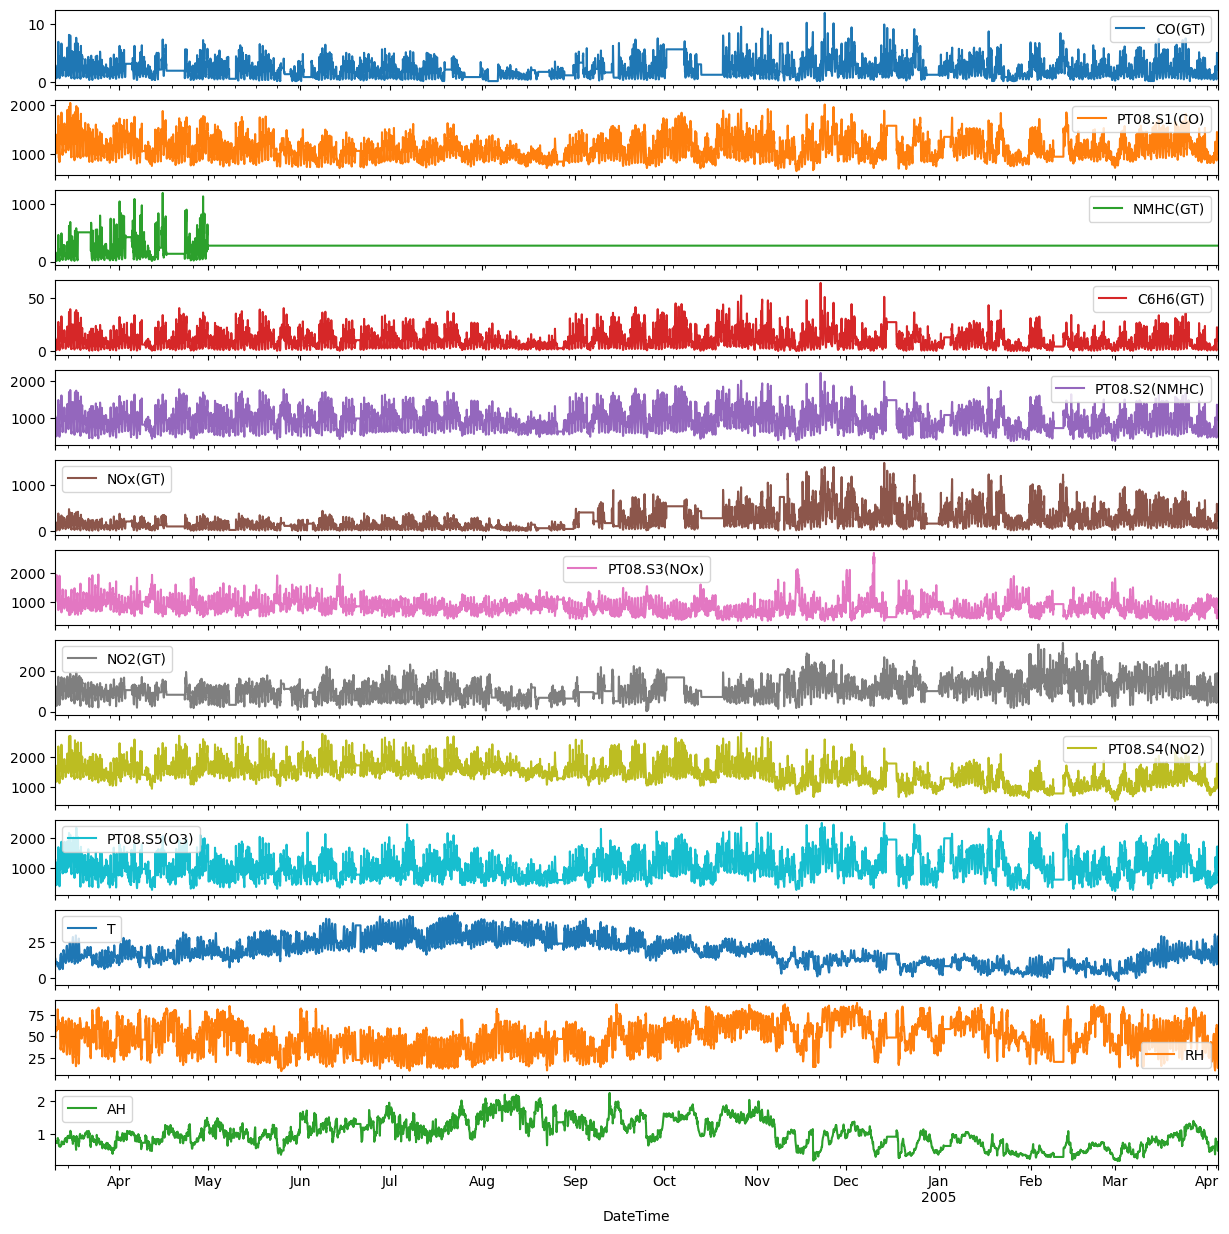

In [39]:
df.plot(subplots = True,figsize = (15,15))

In [40]:
df.drop(['NMHC(GT)','CO(GT)','NO2(GT)','NOx(GT)'],axis = 1,inplace=True)

In [41]:
df.describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1102.604396,10.190299,942.422741,832.618539,1452.890358,1030.388426,18.315768,48.814853,1.017382
std,219.599578,7.565011,269.583076,255.704654,347.427351,410.906048,8.822898,17.354492,0.404829
min,647.250000,0.149048,383.250000,322.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,938.250000,4.401596,732.500000,654.500000,1227.750000,726.000000,11.875000,35.425000,0.726213
50%,1061.500000,8.276765,910.500000,806.750000,1459.750000,963.750000,17.575000,48.925001,0.987539
75%,1237.250000,14.019301,1117.250000,967.500000,1676.750000,1286.500000,24.325000,61.875000,1.306671
max,2039.750000,63.741476,2214.000000,2682.750000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [42]:
scalar = StandardScaler() #MinMax scaler predictions are off
scaled_df = scalar.fit_transform(df)

In [43]:
scaled_df.shape

(9357, 9)

In [44]:
scaled_df

array([[ 1.17217602,  0.22359715,  0.38237848, ..., -0.53452051,
         0.00346606, -0.64136218],
       [ 0.86364346, -0.10484802,  0.04572957, ..., -0.56852475,
        -0.06424344, -0.72107017],
       [ 1.36344344, -0.15763966, -0.01176969, ..., -0.72721123,
         0.29735376, -0.65992597],
       ...,
       [ 0.17940704,  0.28874461,  0.44544219, ...,  0.97300114,
        -1.7555386 , -0.93064808],
       [-0.45587403, -0.08501595,  0.06705994, ...,  1.13452135,
        -2.03213881, -1.24384115],
       [-0.14506448,  0.23025135,  0.38887034, ...,  1.15435723,
        -2.05662945, -1.27116825]])

In [45]:
# target is NO2(GT) column
target = scaled_df[:, 4]
target

array([ 0.68826596,  0.30471205,  0.29247862, ..., -0.61063614,
       -1.1856072 , -0.93374253])

In [46]:
x_train,x_test,y_train,y_test = train_test_split(scaled_df,target,random_state=12,shuffle=False,test_size=0.25)
print(x_train.shape)
print(x_test.shape)

(7017, 9)
(2340, 9)


In [47]:
win_length = 24*7  # one ob each hour (24 per day) * 7 (per week)
batch_size = 32
no_features = 9
train_generator = TimeseriesGenerator(x_train,y_train,length=win_length,batch_size=batch_size,shuffle=False,)
test_generator = TimeseriesGenerator(x_test,y_test,length=win_length,batch_size=batch_size,shuffle=False,)

In [48]:
train_generator[0]

(array([[[ 1.17217602e+00,  2.23597148e-01,  3.82378484e-01, ...,
          -5.34520506e-01,  3.46605516e-03, -6.41362185e-01],
         [ 8.63643456e-01, -1.04848017e-01,  4.57295702e-02, ...,
          -5.68524749e-01, -6.42434417e-02, -7.21070166e-01],
         [ 1.36344344e+00, -1.57639658e-01, -1.17696932e-02, ...,
          -7.27211226e-01,  2.97353765e-01, -6.59925973e-01],
         ...,
         [ 4.75416136e-01,  3.22786271e-02,  1.90405136e-01, ...,
           9.64500104e-01, -1.73536982e+00, -9.07503802e-01],
         [ 1.19608445e+00,  6.57505354e-01,  7.83945920e-01, ...,
           1.24220150e+00, -1.90536369e+00, -9.54754157e-01],
         [ 6.57575582e-01,  2.80057388e-01,  4.37095525e-01, ...,
           1.15435718e+00, -1.95434499e+00, -1.10319155e+00]],
 
        [[ 8.63643456e-01, -1.04848017e-01,  4.57295702e-02, ...,
          -5.68524749e-01, -6.42434417e-02, -7.21070166e-01],
         [ 1.36344344e+00, -1.57639658e-01, -1.17696932e-02, ...,
          -7.27211226

In [98]:
model = Sequential()
model.add(LSTM(128, input_shape = (win_length, no_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128,return_sequences=True))
model.add(Dense(1))
model.add(LSTM(128,return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 168, 128)          70656     
                                                                 
 dropout_4 (Dropout)         (None, 168, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 168, 128)          131584    
                                                                 
 dense_4 (Dense)             (None, 168, 1)            129       
                                                                 
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 269058 (1.03 MB)
Trainable params: 26905

In [99]:
earlystopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min',restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss = 'mse',
              metrics=['mse'])

In [100]:
history = model.fit(train_generator,epochs=50,
                              validation_data=test_generator,
                              shuffle=False,
                              callbacks=[earlystopping])

Epoch 1/50
215/215 [==============================] - 173s 747ms/step - loss: 0.5486 - mse: 0.5486 - val_loss: 0.5404 - val_mse: 0.5404
Epoch 2/50
215/215 [==============================] - 161s 749ms/step - loss: 0.4109 - mse: 0.4109 - val_loss: 0.3159 - val_mse: 0.3159
Epoch 3/50
215/215 [==============================] - 157s 729ms/step - loss: 0.3777 - mse: 0.3777 - val_loss: 0.2567 - val_mse: 0.2567
Epoch 4/50
215/215 [==============================] - 162s 753ms/step - loss: 0.2925 - mse: 0.2925 - val_loss: 0.2218 - val_mse: 0.2218
Epoch 5/50
215/215 [==============================] - 166s 772ms/step - loss: 0.2273 - mse: 0.2273 - val_loss: 0.1559 - val_mse: 0.1559
Epoch 6/50
215/215 [==============================] - 165s 769ms/step - loss: 0.1595 - mse: 0.1595 - val_loss: 0.1148 - val_mse: 0.1148
Epoch 7/50
215/215 [==============================] - 164s 762ms/step - loss: 0.1250 - mse: 0.1250 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 8/50
215/215 [============================

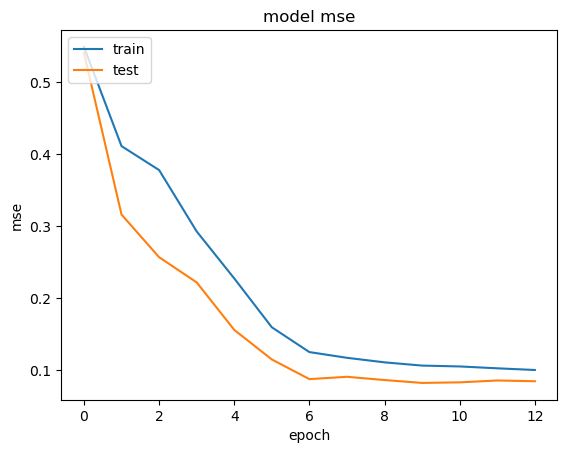

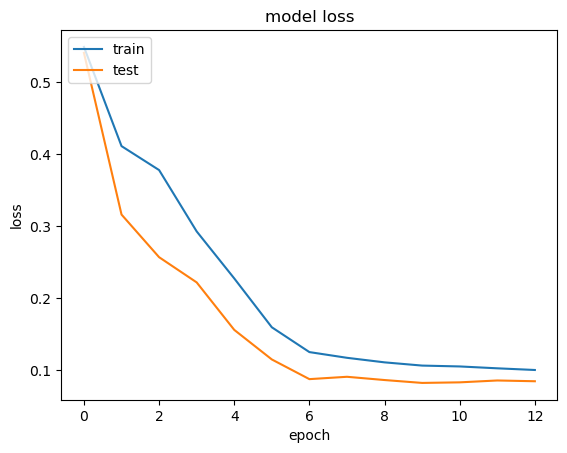

In [101]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [102]:
predictions = model.predict_generator(test_generator)
predictions.shape

C:\Users\admin\AppData\Local\Temp\ipykernel_13696\2557077796.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


(2172, 1)

In [103]:
predictions

array([[-0.45598978],
       [-0.43881476],
       [-0.42213947],
       ...,
       [-0.5398761 ],
       [-0.635695  ],
       [-0.8694353 ]], dtype=float32)

In [104]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [105]:
rev_trans = scalar.inverse_transform(df_pred)

In [106]:
df_final = df[predictions.shape[0]*-1:]

In [107]:
df_final.count()

PT08.S1(CO)      2172
C6H6(GT)         2172
PT08.S2(NMHC)    2172
PT08.S3(NOx)     2172
PT08.S4(NO2)     2172
PT08.S5(O3)      2172
T                2172
RH               2172
AH               2172
dtype: int64

In [108]:
df_final['app_pred'] = rev_trans[:,0]

C:\Users\admin\AppData\Local\Temp\ipykernel_13696\769955142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['app_pred'] = rev_trans[:,0]


<Axes: xlabel='DateTime'>

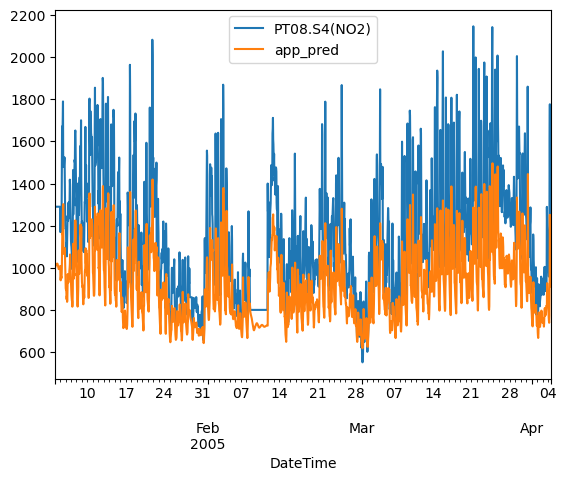

In [109]:
df_final[['PT08.S4(NO2)','app_pred']].plot()